In [1]:
pip install sqlparse requests


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install google.generativeai


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
!pip install langgraph langchain openai


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [4]:
pip install langchain-community



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install mysql-connector-python


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import mysql.connector

def list_all_tables():
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='rootroot'
        )
    cursor = conn.cursor()

    cursor.execute("SHOW DATABASES")
    databases = [db[0] for db in cursor.fetchall()]
    exclude = {'mysql', 'information_schema', 'performance_schema', 'sys'}

    for db in databases:
        if db in exclude:
            continue
        try:
            cursor.execute(f"USE {db}")
            cursor.execute("SHOW TABLES")
            tables = cursor.fetchall()
            print(f"\n  {db}:")
            for (table,) in tables:
                print(f"   {table}")
        except Exception as e:
            print(f"⚠️ Could not access {db}: {e}")

    cursor.close()
    conn.close()

list_all_tables()


  kparuch_final_project:
   Amenities
   Corruption
   Country
   Economy
   economywithgdppercapita
   Health
   Labor
   Social
   Staging

  kparuch_sql:
   access
   category
   customer
   device
   employee
   employees
   facility
   includes
   product
   products_more_than_3_sold
   region
   salestransaction
   store
   vendor

  layoffs:
   employee
   layoffs_data
   layoffs_staging
   layoffs_staging2
   test

  sakila:
   actor
   actor_info
   address
   category
   city
   country
   customer
   customer_list
   film
   film_actor
   film_category
   film_list
   film_text
   inventory
   language
   nicer_but_slower_film_list
   payment
   rental
   sales_by_film_category
   sales_by_store
   staff
   staff_list
   store


In [13]:
from langgraph.graph import StateGraph
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
import sqlparse
import sqlparse.tokens as T
import mysql.connector
import google.generativeai as genai

genai.configure(api_key="")
llm = genai.GenerativeModel('gemini-2.0-flash-lite')

def load_schema_node(state):
    conn = mysql.connector.connect(
        host='localhost',
        user='root',
        password='rootroot',
        database='sakila'  
    )
    cursor = conn.cursor()

    cursor.execute("SHOW TABLES")
    tables = [row[0] for row in cursor.fetchall()]

    schema_lines = []

    for table in tables:
        cursor.execute(f"DESCRIBE {table}")
        columns = cursor.fetchall()
        column_defs = [f"{col[0]} ({col[1]})" for col in columns]
        schema_lines.append(f"Table: {table}\nColumns: {', '.join(column_defs)}")

    cursor.close()
    conn.close()

    schema_str = "\n\n".join(schema_lines)
    state["schema"] = schema_str
    state["database"] = "sakila"  
    return state


def generate_sql_node(state):
    prompt = ChatPromptTemplate.from_template("""
        You are a SQL generator. Use **MySQL syntax**.
        
        Given this schema:
        
        {schema}
        
        And this question:
        
        {question}
        
        Generate only the valid SQL query without any extra information.
        Use MySQL-specific functions like YEAR() instead of STRFTIME. Don't use SQLite syntax.
        """)

    formatted_prompt = prompt.format_messages(schema=state["schema"], question=state["question"])
    
    result = llm.generate_content(formatted_prompt[0].content)
    state["sql"] = result.text.strip().split("```sql")[1].split("```")[0]
    return state


def validate_sql_node(state):
    try:
        parsed = sqlparse.parse(state["sql"])
        if not parsed or not parsed[0]:
            state["valid"] = False
        else:
            stmt = parsed[0]
            first_token = stmt.token_first(skip_cm=True)
            state["valid"] = (
                first_token and 
                first_token.ttype is T.DML and 
                first_token.value.upper() in {"SELECT", "UPDATE", "INSERT", "DELETE"}
            )
    except Exception as e:
        print("Validation error:", e)
        state["valid"] = False
    return state


def explain_output_node(state):
    state["answer"] = f"{state['sql']}"
    return state

def explain_nl_node(state):
    prompt = ChatPromptTemplate.from_template("""
            You are a SQL interpreter and explainer.
            
            Given the following SQL query:
            
            {sql}
            
            Provide a detailed, step-by-step explanation of what this query does.
            
            For each part of the query:
            - Explain each JOIN and why it's used.
            - Describe the purpose of each WHERE clause.
            - Explain any GROUP BY, ORDER BY, or aggregation logic.
            - Clarify the overall goal of the query.
            - If applicable, explain any subqueries or window functions.
            - Make it understandable to someone familiar with SQL but not this specific schema.
            
            Avoid repeating the SQL — focus on explanation, not translation.
            """)

    formatted_prompt = prompt.format_messages(sql=state["sql"])
    
    result = llm.generate_content(formatted_prompt[0].content)
    state["nl_explanation"] = result.text.strip()
    return state

def execute_sql_node(state):
    try:
        conn = mysql.connector.connect(
            host="localhost",
            user="root",
            password="rootroot",
            database=state["database"]
        )
        cursor = conn.cursor()
        cursor.execute(state["sql"])

        if cursor.description: 
            columns = [desc[0] for desc in cursor.description]
            rows = cursor.fetchall()
            formatted_result = [dict(zip(columns, row)) for row in rows]
            state["query_result"] = formatted_result
        else:  
            conn.commit()
            state["query_result"] = f"Query OK, {cursor.rowcount} row(s) affected."

    except Exception as e:
        state["query_result"] = f" Error running SQL: {e}"
    finally:
        cursor.close()
        conn.close()

    return state


In [10]:
from typing import TypedDict, Optional

class AgentState(TypedDict):
    question: str
    schema: str
    intent: Optional[str]
    sql: Optional[str]
    valid: Optional[bool]
    answer: Optional[str]
    nl_explanation: Optional[str]
    query_result: Optional[any]
    database: Optional[str]  


from langgraph.graph import StateGraph

builder = StateGraph(state_schema=AgentState)

builder.add_node("load_schema", load_schema_node)

builder.add_node("generate_sql", generate_sql_node)
builder.add_node("validate_sql", validate_sql_node)
builder.add_node("explain_output", explain_output_node)
builder.add_node("explain_nl", explain_nl_node)
builder.add_node("execute_sql", execute_sql_node)

builder.set_entry_point("load_schema")
builder.add_edge("load_schema", "generate_sql")
builder.add_edge("generate_sql", "validate_sql")
# builder.add_edge("validate_sql", "explain_output")
# builder.add_edge("explain_output", "explain_nl")

builder.add_edge("validate_sql", "execute_sql")
builder.add_edge("execute_sql", "explain_output")
builder.add_edge("explain_output", "explain_nl")

app = builder.compile()


In [14]:
input_state = {"question": "List all names in the in actor table"}

final_state = app.invoke(input_state)

print(final_state["answer"])


E0000 00:00:1759530217.859735  625652 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.



SELECT first_name, last_name
FROM actor;



In [15]:
final_state = app.invoke({"question": "Show city names of actors whos name starts with A"})
print(final_state["answer"])


SELECT DISTINCT
  city.city
FROM actor
JOIN actor_info
  ON actor.actor_id = actor_info.actor_id
JOIN address
  ON actor_info.actor_id = address.address_id
JOIN city
  ON address.city_id = city.city_id
WHERE
  actor.first_name LIKE 'A%';



In [16]:
final_state = app.invoke({
    "question": """Find the top 5 customers who have spent the most money on rentals in the year 2006. 
For each of these customers, list their full name, total amount spent, number of rentals, and their favorite film category 
(based on the number of rentals in that category)."""
})


In [17]:
print("SQL Query:", final_state["sql"])
print("\n\nExplanation:", final_state["nl_explanation"])
print("\n\nQuery Result:")
print(final_state["query_result"])

SQL Query: 
SELECT
  c.first_name,
  c.last_name,
  SUM(p.amount) AS total_spent,
  COUNT(r.rental_id) AS number_of_rentals,
  (
    SELECT
      ca.name
    FROM category AS ca
    JOIN film_category AS fc
      ON ca.category_id = fc.category_id
    JOIN inventory AS i
      ON fc.film_id = i.film_id
    JOIN rental AS r2
      ON i.inventory_id = r2.inventory_id
    WHERE
      r2.customer_id = c.customer_id
      AND YEAR(r2.rental_date) = 2006
    GROUP BY
      ca.name
    ORDER BY
      COUNT(r2.rental_id) DESC
    LIMIT 1
  ) AS favorite_category
FROM customer AS c
JOIN payment AS p
  ON c.customer_id = p.customer_id
JOIN rental AS r
  ON c.customer_id = r.customer_id
WHERE
  YEAR(p.payment_date) = 2006
GROUP BY
  c.customer_id
ORDER BY
  total_spent DESC
LIMIT 5;



Explanation: Okay, here's a detailed breakdown of the SQL query, explaining each part and its purpose.

**Overall Goal:**

The main goal of this query is to identify the top 5 customers who spent the most money in 

In [18]:
final_state = app.invoke({"question": "List all employees in the Finance department"})
print("SQL:", final_state["answer"])
print("Explanation:", final_state["nl_explanation"])

SQL: 
-- The provided schema does not contain information about the finance department or any departments.
-- Returning all employees as no other table or field can satisfy the request.
SELECT first_name, last_name
FROM staff;

Explanation: Okay, here's a breakdown of the SQL query, designed to be clear and understandable for someone who knows SQL in general:

**Overall Goal:**

The query aims to retrieve the first and last names of all employees. This is based on the query's selection of `first_name` and `last_name` from the `staff` table. The comments indicate that the specific request (likely involving information about finance or other departments) could not be fulfilled because the relevant data or tables were not present in the provided schema. Therefore, it defaults to providing basic employee information.

**Step-by-Step Explanation:**

1.  **`SELECT first_name, last_name`**: This is the selection part of the query. It specifies which columns we want to see in the final result.

In [26]:
state = {"question": "List all employees in the Sales department"}

state = load_schema_node(state)
state = generate_sql_node(state)

print(state["sql"])



-- There is no Sales department information in any of the tables provided.
-- Returning staff information instead.
SELECT staff_id, first_name, last_name
FROM staff;



In [38]:
state = {"question": "update the start date for all employees in the Sales department to 12/12/2024"}

state = load_schema_node(state)
state = generate_sql_node(state)
print("Generated SQL:\n", state["sql"])


Generated SQL:
 
-- The provided database schema doesn't contain a table for "employees" or a "Sales" department with a "start_date".
-- Therefore, it is impossible to fulfil the request without the correct schema.
-- Returning an example update query on the 'staff' table instead.
-- Replace 'staff' and the 'start_date' with the appropriate table and column names in the actual database schema.
UPDATE staff
SET last_update = '2024-12-12'
WHERE staff_id IN (SELECT staff_id FROM staff);



In [73]:
pip install graphviz ipywidgets


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


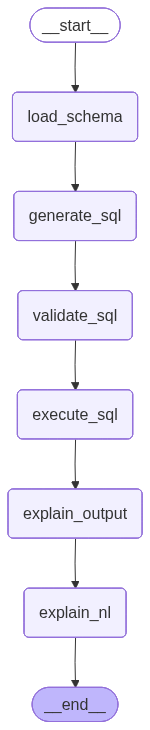

In [74]:
from IPython.display import Image, display
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
  pass